In [92]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
import pandas as pd
import datetime
import os

In [93]:
def update_connections(n, T, A, opinions, confidence):
    new_A = np.zeros_like(A)
    for i in range(n):
        for j in range(i + 1, n):
            disagreements = np.abs(opinions[i] - opinions[j])
            similarities = (disagreements <= confidence).sum()
            S_ij = similarities / T
            P_ij = 1 / (1 + np.exp(-10 * (S_ij - 0.5)))  # sigmoid函数作为新的连接概率
            new_A[i, j] = new_A[j, i] = np.random.rand() < P_ij
    return new_A

In [94]:
def update_opinions(n, T, A, opinions, confidence):
    new_opinions = opinions.copy()
    for i in range(n):
        for j in range(n):
            if A[i, j] == 1:    
                disagreements = np.abs(opinions[i] - opinions[j])
                for k in range(T):
                    # 计算协商范围
                    similarities = (disagreements <= confidence[k]).sum()
                    differences = T - similarities
                    mu = float('inf') if differences == 0 \
                        else confidence[k] * similarities / differences
                    if disagreements[k] <= mu:
                        P_ij = 1 / (1 + np.exp(-10 * (disagreements[k] - 0.5)))
                        new_opinions[i, k] = (1 - P_ij) * opinions[i, k] + P_ij * opinions[j, k]
                        new_opinions[j, k] = (1 - P_ij) * opinions[j, k] + P_ij * opinions[i, k]
    return new_opinions


In [95]:
def create_ba_network(n, m):
    """
    生成一个BA无标度网络。
    :param n: 网络中的节点总数
    :param m: 每个新增节点连接的旧节点数
    :return: BA网络的邻接矩阵
    """
    ba = nx.barabasi_albert_graph(n, m)
    return nx.to_numpy_array(ba)

In [96]:
def create_ws_network(n, k, p):
    """
    生成一个WS小世界网络。
    :param n: 网络中的节点数量
    :param k: 每个节点的邻居数（最近的k/2个节点）
    :param p: 重连边的概率
    :return: WS小世界网络的邻接矩阵
    """
    ws = nx.watts_strogatz_graph(n, k, p)
    return nx.to_numpy_array(ws)

In [97]:
def create_community_network(n, block_sizes, p_intra, p_inter):
    """
    生成一个社团结构网络。
    :param n: 网络中的节点数量
    :param block_sizes: 各社团内的节点数列表
    :param p_intra: 社团内节点之间连接的概率
    :param p_inter: 社团间节点之间连接的概率
    :return: 社团结构网络的邻接矩阵
    """
    sizes = [int(n * size) for size in block_sizes]
    probs = [[p_intra if i == j else p_inter for j in range(len(sizes))] for i in range(len(sizes))]
    community = nx.stochastic_block_model(sizes, probs)
    return nx.to_numpy_array(community)


In [98]:
def run(n, T, A, label, max_steps=30):
    """
    :param n: 网络中的节点（个体）数量
    :param T: 话题数量
    :param A: 初始邻接矩阵
    :max_steps: 最大迭代次数
    """
    # 初始化观点向量，每个话题的观点值为标准正态分布随机样本
    opinions = np.random.randn(n, T)

    # 为每个话题生成置信度ε_k，并确保值在0到1之间
    confidence = truncnorm(a=0, b=1, loc=0.5, scale=0.15).rvs(size=T)

    # 随机选择1个话题作为错误信息
    topic_to_track = np.random.choice(range(T), 1, replace=False)[0]

    opinions_history = np.zeros((n, max_steps))  # 存储每个个体的观点历史

    for step in range(max_steps):
        new_A = update_connections(n, T, A, opinions, confidence)
        new_opinions = update_opinions(n, T, new_A, opinions, confidence)
        
        # 存储当前所有个体的选定话题的观点
        opinions_history[:, step] = new_opinions[:, topic_to_track]
        
        # 检查是否达到稳态
        if np.allclose(new_A, A) and np.allclose(new_opinions, opinions):
            break
        
        A, opinions = new_A, new_opinions

    # 将数据保存到CSV文件
    time_stamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    file_name = f'{label}-{time_stamp}'
    folder_name = f'logs/{file_name}'
    if not os.path.exists('logs'):
        os.makedirs('logs')
    os.makedirs(folder_name)
    pd.DataFrame(opinions_history).to_csv(f'{folder_name}/{file_name}.csv', index=False)

    plt.figure(figsize=(12, 6))
    for i in range(n):
        plt.plot(opinions_history[i])

    plt.xlabel(f'Time Steps ({label})')
    plt.ylabel('Individual Opinions')
    plt.title(f'Number of individuals={n}')
    plt.savefig(f'{folder_name}/{file_name}.png')
    plt.show()

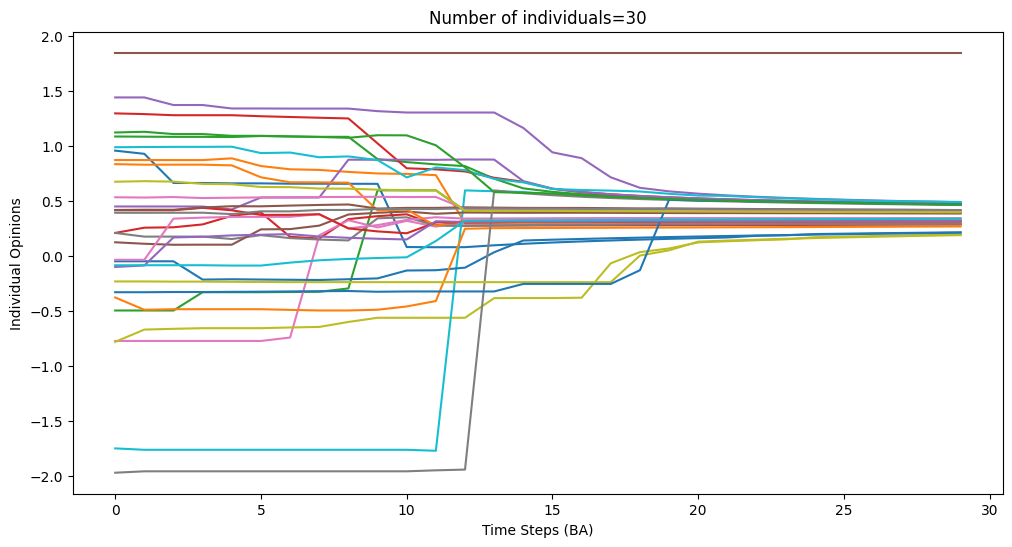

In [99]:
n = 30
T = 20
run(n=n, T=T, label='BA', A=create_ba_network(n, 5), max_steps=30)

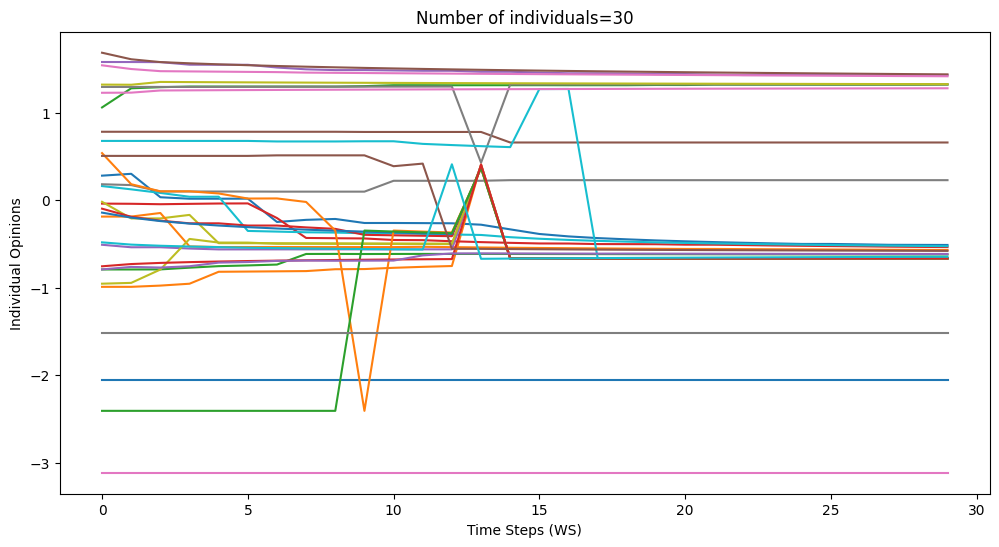

In [100]:
run(n=n, T=T, label='WS', A=create_ws_network(n=n, k=10, p=0.1), max_steps=30)

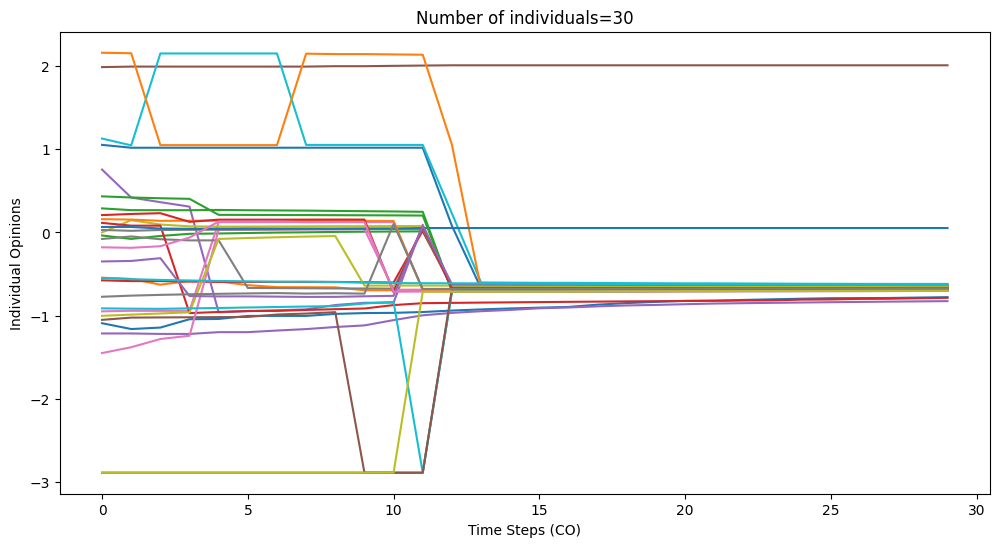

In [101]:
run(n=n, 
    T=T, 
    label='CO',
    A=create_community_network(
        n=n, 
        block_sizes=[0.4, 0.3, 0.3], 
        p_intra=0.8,
        p_inter=0.05), 
    max_steps=30)

In [102]:
def plot_from_csv(csv_file: str):
    """
    从CSV文件读取数据并绘制图表。
    :param csv_file: 存储观点历史的CSV文件路径。        
    """
    # 读取CSV文件
    df = pd.read_csv(csv_file)

    # 读取标签
    # BA：无标度网络
    # WS：小世界网络
    # CO：社团结构网络
    label = csv_file.split('/')[-1].split('-')[0]
    
    # 转换为 numpy 数组以便绘图
    data = df.values
    
    # 绘图
    plt.figure(figsize=(12, 6))
    for i in range(data.shape[0]):
        plt.plot(data[i])
    
    plt.xlabel(f'Time Steps ({label})')
    plt.ylabel('Individual Opinions')
    plt.title(f'Number of individuals={n}')
    plt.show()

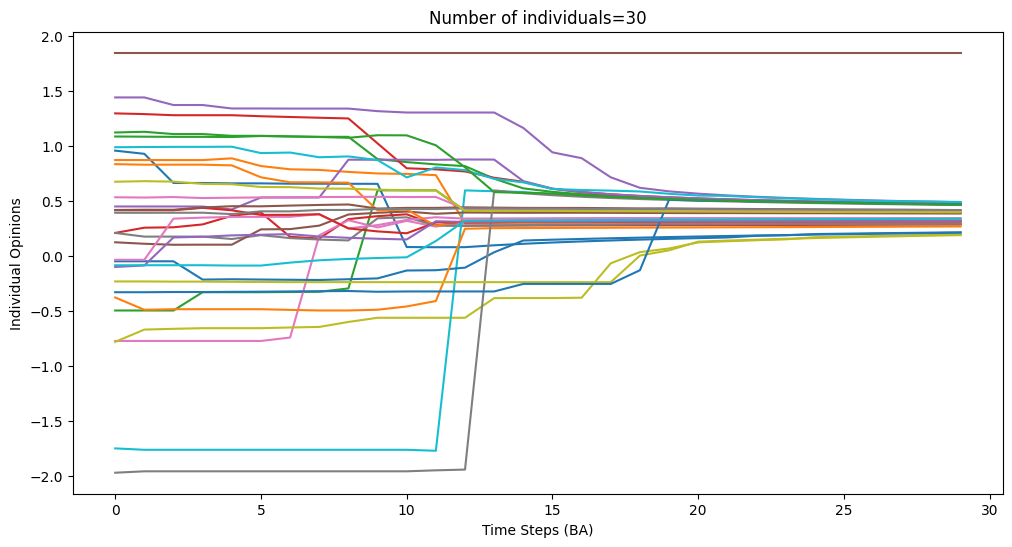

In [104]:
plot_from_csv('logs/BA-20240625_191728/BA-20240625_191728.csv')